In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import math, sys
from matplotlib import pyplot as plt
%matplotlib inline

## Directly read in daily MAPEs from PyCharmm Running

In [2]:
mapes_out = pd.read_csv('./MAPEs/Clean_Daily_V311_APE_XGB_9_70_3_03_OUT.csv')
mapes_out.drop('Unnamed: 0', axis=1, inplace=True)

mapes_in = pd.read_csv('./MAPEs/Clean_Daily_V311_APE_XGB_9_70_3_03_IN.csv')
mapes_in.drop('Unnamed: 0', axis=1, inplace=True)

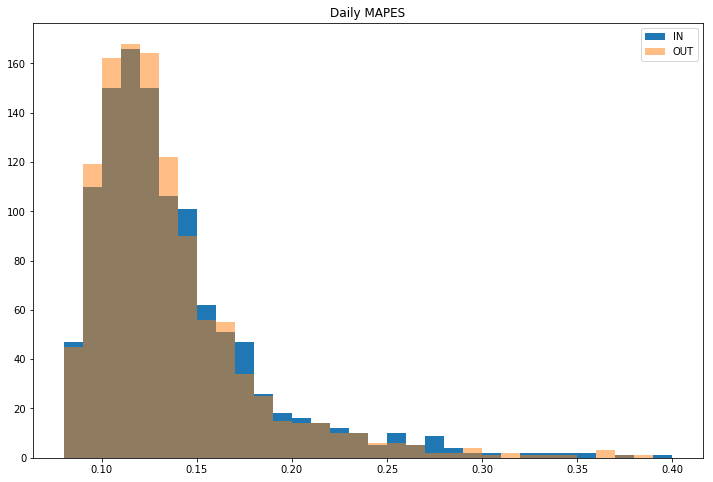

In [3]:
bins_0_1 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1.0]

bins_0_04 = [0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
             0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27, 0.28,
             0.29, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 
             0.36, 0.37, 0.38, 0.39, 0.40]
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
counts, bins, fig = ax1.hist(mapes_in.mapes, bins=bins_0_04)
counts, bins, fig = ax1.hist(mapes_out.mapes, bins=bins_0_04, alpha=0.5)
ax1.set_title('Daily MAPES')
ax1.legend(['IN', 'OUT'])
plt.savefig('./MAPEs_Dist/Clean_Daily_V311_APE_XGB_9_70_3_03_daily.png')

In [4]:
def getDiff(x0, x1):
    if x0 == 0:
        return 0
    else:
        return abs(x0 - x1)
    
def getAPE(x0, x1):
    if x1 == 0:
        return None
    else:
        return x0 / x1
    
def getSMAPE(x0, x1):
    if x0 == 0:
        return None
    else:
        return 2 * abs(x0 - x1) / (x0 + x1)

### Define function to get WMAPE

In [5]:
def getStoreWMAPE(df_s):
    
    # Check the needed columns are in the dataset for each of the stores.
    cols_need = ['TRFFC_DTE', 'Date', 'trffc_true', 'trffc_pred']
    missed = [i for i in cols_need if i not in df_s.columns.tolist()]
    if len(missed) != 0:
        print('Needed columns: ', cols_need)
        raise ValueError("Missing columns: {}".format(missed))
    
    # Get hourly prediction difference with true traffic.
    df_s['diff_trffc_hr'] = df_s[['trffc_true', 'trffc_pred']].apply(lambda x: getDiff(x[0], x[1]), axis=1)
    
    # Get daily total traffic. 
    daily_sum = df_s[['Date', 
                'trffc_true']].groupby(['Date']).agg({'trffc_true':np.sum}).reset_index()
    daily_sum.rename(columns={'trffc_true':'daily_sum'}, inplace=True)
    
    # Get daily difference totdal.
    daily_diff_sum = df_s[['Date', 
                'diff_trffc_hr']].groupby(['Date']).agg({'diff_trffc_hr':np.sum}).reset_index()
    daily_diff_sum.rename(columns={'diff_trffc_hr':'daily_diff_sum'}, inplace=True)
    
    # Get the total true hourly traffic and daily total of hourly difference.
    df_wmape = daily_sum.merge(daily_diff_sum, on=['Date'], how='left')
    
    # Get WMAPE.
    df_wmape['wmape'] = df_wmape[['daily_diff_sum', 'daily_sum']].apply(lambda x: getAPE(x[0], x[1]), axis=1)
    
    # Get the WMAPE value.
    wmape = df_wmape['wmape'].mean()
    
    return wmape

In [6]:
def getStoreSMAPE(df_s):
    
    # Check the needed columns are in the dataset for each of the stores.
    cols_need = ['TRFFC_DTE', 'Date', 'trffc_true', 'trffc_pred']
    missed = [i for i in cols_need if i not in df_s.columns.tolist()]
    if len(missed) != 0:
        print('Needed columns: ', cols_need)
        raise ValueError("Missing columns: {}".format(missed))
    
    # Get hourly prediction difference with true traffic.
    df_s['SAPE'] = df_s[['trffc_true', 'trffc_pred']].apply(lambda x: getSMAPE(x[0], x[1]), axis=1)
    
    smape = df_s['SAPE'].mean()
    
    return smape

### Parameters

In [7]:
start_date = '2018-07-01'
end_date = '2018-07-28'

In [8]:
store_list_mine = [7, 8, 9, 10, 14, 17, 18, 19, 25, 31, 32, 34, 35, 37, 41, 43, 48, 49, 54, 55, 57, 60, 62, 63, 64, 70, 71, 72, 73, 75, 77, 79, 84, 86, 89, 91, 95, 96, 97, 101, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118, 119, 121, 123, 125, 126, 127, 129, 130, 132, 134, 136, 138, 139, 140, 141, 143, 147, 148, 149, 153, 154, 155, 156, 158, 159, 160, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 182, 183, 184, 185, 186, 187, 188, 189, 191, 193, 195, 196, 197, 198, 202, 204, 205, 206, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 241, 242, 244, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 293, 296, 297, 298, 299, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 325, 326, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 369, 370, 371, 372, 373, 377, 379, 380, 381, 382, 383, 384, 385, 386, 388, 389, 394, 395, 397, 398, 399, 401, 403, 405, 406, 407, 408, 409, 411, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 432, 433, 435, 436, 437, 438, 439, 440, 441, 442, 444, 445, 446, 447, 449, 450, 451, 453, 454, 455, 456, 457, 458, 460, 461, 462, 463, 464, 465, 466, 468, 469, 470, 471, 472, 473, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 493, 494, 495, 496, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 542, 544, 545, 547, 548, 549, 550, 551, 552, 553, 555, 557, 559, 560, 562, 563, 564, 565, 567, 568, 569, 570, 571, 574, 575, 576, 577, 579, 581, 584, 585, 586, 587, 588, 589, 590, 591, 593, 595, 596, 598, 601, 602, 605, 608, 609, 611, 612, 613, 614, 615, 616, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 630, 631, 633, 634, 636, 638, 639, 640, 642, 643, 644, 645, 646, 652, 653, 654, 656, 657, 658, 659, 662, 663, 664, 667, 668, 669, 673, 674, 675, 677, 678, 679, 680, 681, 682, 685, 686, 687, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 701, 702, 703, 704, 705, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 720, 721, 722, 723, 724, 725, 726, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 755, 756, 757, 758, 759, 760, 761, 762, 763, 765, 766, 767, 768, 769, 770, 771, 773, 774, 776, 777, 778, 779, 780, 782, 783, 784, 785, 786, 787, 788, 790, 795, 796, 797, 798, 799, 951, 952, 953, 954, 955, 956, 957, 958, 960, 962, 963, 964, 967, 968, 969, 971, 973, 975, 976, 977, 980, 981, 982, 983, 985, 986, 987, 988, 990, 991, 992, 994, 995, 997, 998, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1027, 1028, 1030, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1040, 1041, 1042, 1043, 1045, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1055, 1056, 1057, 1058, 1059, 1060, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1075, 1076, 1077, 1078, 1079, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1115, 1117, 1118, 1119, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1145, 1147, 1149, 1151, 1153, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1167, 1169, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1202, 1203, 1204, 1205, 1207, 1209, 1211, 1212, 1215, 1216, 1217, 1219, 1221, 1223, 1224, 1225, 1227, 1228, 1230, 1232, 1233, 1236, 1237, 1238, 1240, 1241, 1242, 1243, 1245, 1249, 1250, 1253, 1255, 1256, 1257, 1261, 1262, 1264, 1265, 1266, 1267, 1268, 1269, 1272, 1275, 1277, 1279, 1281, 1282, 1283, 1284, 1285, 1286, 1288, 1290, 1291, 1292, 1293, 1294, 1295, 1300, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1324, 1326, 1327, 1328, 1329, 1330, 1332, 1334, 1340, 1342, 1343, 1347, 1349, 1350, 1352, 1353, 1354, 1355, 1356, 1357, 1359, 1361, 1362, 1363, 1365, 1370, 1372, 1373, 1374, 1377, 1378, 1381, 1382, 1383, 1385, 1386, 1388, 1389, 1390, 1391, 1393, 1394, 1395, 1396, 1397, 1399, 1400, 1401, 1403, 1404, 1405, 1407, 1408, 1409, 1410, 1411, 1413, 1415, 1416, 1418, 1419, 1420, 1421, 1422, 1424, 1425, 1426, 1428, 1429, 1430, 1431, 1432, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1445, 1447, 1453, 1454, 1455, 1456, 1458, 1462, 1463, 1466, 1467, 1468, 1469, 1470, 1474, 1476, 1480, 1481, 1482, 1483, 1484, 1487, 1492, 1493, 1494, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1506, 1507, 1508, 1510, 1515, 1516, 1517, 1518, 1519, 1520, 1522, 1529, 1530]

### Read in Celect prediction and calculate WMAPE

In [9]:
df = pd.read_csv('./CelectResults/traffic-in-backtest-sample.csv')

In [10]:
df.head(3)

,period_start,period_end,store_id,product_id,demand,model-last-updated,true_value,store_smape_hourly_14,store_smape_hourly_28,store_smape_hourly_56,store_smape_daily_14,store_smape_daily_28,store_smape_daily_56
0,2018-06-03T00:00:00,2018-06-03T01:00:00,7,NaN,53.233763,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603
1,2018-06-03T01:00:00,2018-06-03T02:00:00,7,NaN,53.771452,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603
2,2018-06-03T02:00:00,2018-06-03T03:00:00,7,NaN,52.156366,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603


In [11]:
df['TRFFC_DTE'] = pd.to_datetime(df['period_start'], infer_datetime_format=True)
df['Date'] = df['TRFFC_DTE'].dt.strftime('%Y-%m-%d')

df = df[['store_id', 'TRFFC_DTE', 'Date', 'demand', 'true_value']]

df.rename(columns={'demand':'trffc_pred', 'true_value':'trffc_true'}, inplace=True)

In [12]:
df_records = df[['store_id', 'trffc_true']].groupby(['store_id']).count().reset_index()
df_records.to_csv('celect_prediction_number_records.csv')
print(df.TRFFC_DTE.min())
print(df.TRFFC_DTE.max())

2018-06-03 00:00:00
2018-07-28 23:00:00


In [13]:
df.head(3)

,store_id,TRFFC_DTE,Date,trffc_pred,trffc_true
0,7,2018-06-03 00:00:00,2018-06-03,53.233763,0
1,7,2018-06-03 01:00:00,2018-06-03,53.771452,0
2,7,2018-06-03 02:00:00,2018-06-03,52.156366,0


In [14]:
store_list_celect = df.store_id.unique().tolist()

In [15]:
def getCleanTrffc(x0, x1, x2, x3):
    
    if x0 >= x2 and x0 < x3:
        return x1
    else:
        return 0

In [16]:
d_celect = {}
d_celect['store'] = []
d_celect['WMAPE'] = []
d_celect['SMAPE'] = []

for store_id in [i for i in store_list_mine if i in store_list_celect]:
    df_store = df[df['store_id'] == store_id].copy()
    df_store['trn_sls_dte'] = pd.to_datetime(df_store['Date'], infer_datetime_format=True)
    df_store['Date'] = df_store['trn_sls_dte'].dt.strftime("%Y-%m-%d")
    df_store = df_store[(df_store['Date'] >= start_date) & (df_store['Date'] <= end_date)]
    
    df_hour = pd.read_csv('./StoreOpenHours/StoreHour_' + str(store_id) + '.csv')
    df_hour['trn_sls_dte'] = pd.to_datetime(df_hour['Date'], infer_datetime_format=True)
    df_hour['Date'] = df_hour['trn_sls_dte'].dt.strftime("%Y-%m-%d")
    
    # Use store hour to clean traffic data.
    df_store = df_store.merge(df_hour, on=['Date'], how='left')
    df_store['hour'] = df_store['TRFFC_DTE'].dt.hour
    df_store['trffc_true_clean'] = df_store[['hour', 'trffc_true', 'open', 
                                             'close']].apply(lambda x: getCleanTrffc(x[0], x[1], x[2], x[3]), axis=1)
    
    df_store.drop('trffc_true', inplace=True, axis=1)
    df_store.rename(columns={'trffc_true_clean':'trffc_true'}, inplace=True)
    
    d_celect['store'].append(store_id)
    t = getStoreWMAPE(df_store)
    d_celect['WMAPE'].append(t)
    t2 = getStoreSMAPE(df_store)
    d_celect['SMAPE'].append(t2)
    
df_store_celect_check = df_store.copy()

In [17]:
wmapes_celect = pd.DataFrame(d_celect)
wmapes_celect.to_csv('./CelectResults/Comparison_celect_July_WMAPEs.csv')

### Read in my prediction and calculate WMAPE

In [18]:
df_mine = pd.read_csv(
    './000Deliverables/Clean_Daily_V311_APE_XGB_9_70_3_03_IN/Clean_Daily2Hourly_V311_APE_XGB_9_70_3_03_IN.csv')

df_mine['TRFFC_DTE'] = pd.to_datetime(df_mine['Date'], infer_datetime_format=True)
df_mine['Date'] = df_mine['TRFFC_DTE'].dt.strftime('%Y-%m-%d')

df_mine = df_mine[['STR_ID', 'Date', 'SALEHOUR','IN_Clean', 'pred_hourly']]

df_mine.rename(columns={'pred_hourly':'trffc_pred', 'IN_Clean':'trffc_true'}, inplace=True)

In [19]:
d_mine = {}
d_mine['store'] = []
d_mine['WMAPE'] = []
d_mine['SMAPE'] = []

for store_id in [i for i in store_list_mine]:
    df_store = df_mine[df_mine['STR_ID'] == store_id].copy()
    df_store['trn_sls_dte'] = pd.to_datetime(df_store['Date'], infer_datetime_format=True)
    df_store['Date'] = df_store['trn_sls_dte'].dt.strftime("%Y-%m-%d")
    df_store['TRFFC_DTE'] = pd.to_datetime(df_store.Date + ' ' + df_store['SALEHOUR'].astype('str') + ':00:00',
                                    infer_datetime_format=True)
    df_store = df_store[(df_store['Date'] >= start_date) & (df_store['Date'] <= end_date)]
    
    d_mine['store'].append(store_id)
    t = getStoreWMAPE(df_store)
    d_mine['WMAPE'].append(t)
    t2 = getStoreSMAPE(df_store)
    d_mine['SMAPE'].append(t2)
    
df_store_mine_check = df_store.copy()

wmapes_mine = pd.DataFrame(d_mine)
wmapes_mine.to_csv('./CelectResults/Comparison_mine_July_WMAPEs.csv')

In [20]:
df_mine[(df_mine['Date'] == '2018-08-10') & (df_mine['SALEHOUR'] == 18)][:10]

,STR_ID,Date,SALEHOUR,trffc_true,trffc_pred
1650,7,2018-08-10,18,351.0,347.487767
4842,8,2018-08-10,18,241.0,320.381224
8034,9,2018-08-10,18,154.0,184.517219
11226,10,2018-08-10,18,173.0,227.141727
14370,11,2018-08-10,18,376.0,339.004613
17562,14,2018-08-10,18,132.0,169.175835
20754,17,2018-08-10,18,155.0,184.029688
23946,18,2018-08-10,18,158.0,203.657342
27138,19,2018-08-10,18,115.0,142.803182
30330,25,2018-08-10,18,85.0,108.119870


### Read in Bayone prediction and calculate WMAPE

In [21]:
df_bayone = pd.read_csv('./000BayoneResults/VSTR_IN_CNT_2018-07-01_Hourly.csv')
df_bayone['trn_sls_dte'] = pd.to_datetime(df_bayone['TRFFC_DTE'], infer_datetime_format=True)
df_bayone['Date'] = df_bayone['trn_sls_dte'].dt.strftime('%Y-%m-%d')

df_bayone = df_bayone[['STR_ID', 'Date', 'SALEHOUR','Vistor_Pred_Hourly', 'VSTR_IN_CNT_HOUR']]

df_bayone.rename(columns={'Vistor_Pred_Hourly':'trffc_pred', 'VSTR_IN_CNT_HOUR':'trffc_true'}, inplace=True)

In [22]:
store_list_bayone = df_bayone.STR_ID.tolist()

In [23]:
d_bayone = {}
d_bayone['store'] = []
d_bayone['WMAPE'] = []
d_bayone['SMAPE'] = []

for store_id in [i for i in store_list_mine if i in store_list_bayone]:
    df_store = df_bayone[df_bayone['STR_ID'] == store_id].copy()
    df_store['trn_sls_dte'] = pd.to_datetime(df_store['Date'], infer_datetime_format=True)
    df_store['Date'] = df_store['trn_sls_dte'].dt.strftime("%Y-%m-%d")
    df_store['TRFFC_DTE'] = pd.to_datetime(df_store.Date + ' ' + df_store['SALEHOUR'].astype('str') + ':00:00',
                                    infer_datetime_format=True)
    df_store = df_store[(df_store['Date'] >= start_date) & (df_store['Date'] <= end_date)]
    
    d_bayone['store'].append(store_id)
    t = getStoreWMAPE(df_store)
    d_bayone['WMAPE'].append(t)
    t2 = getStoreSMAPE(df_store)
    d_bayone['SMAPE'].append(t2)
    
df_store_bayone_check = df_store.copy()

wmapes_bayone = pd.DataFrame(d_bayone)
wmapes_bayone.to_csv('./CelectResults/Comparison_bayone_July_WMAPEs.csv')

### Read in my prediction and calculate WMAPE

One store prediction in one file

In [24]:
if False: 
    d_mine = {}
    d_mine['store'] = []
    d_mine['WMAPE'] = []
    d_mine['SMAPE'] = []

    for store_id in store_list_mine:
        df_store = pd.read_csv('./Clean_Daily2Hourly_V311_APE_XGB_9_70_3_03/Error_APE_' + str(store_id) + '.csv')

        # Get data into string
        df_store['trn_sls_dte'] = pd.to_datetime(df_store['Date'], infer_datetime_format=True)
        df_store['Date'] = df_store['trn_sls_dte'].dt.strftime("%Y-%m-%d") 
        df_store = df_store[(df_store['Date'] >= start_date) & (df_store['Date'] <= end_date)]

        # Get TRFFC_DTE column.
        df_store['TRFFC_DTE'] = pd.to_datetime(df_store.Date + ' ' + df_store['SALEHOUR'].astype('str') + ':00:00', 
                                      infer_datetime_format=True)

        # Rename columns into the needed column names.
        df_store.rename(columns={'pred_hourly':'trffc_pred', 'IN_Clean':'trffc_true'}, inplace=True)

        df_store = df_store[['TRFFC_DTE', 'Date', 'trffc_true', 'trffc_pred']]

        d_mine['store'].append(store_id)
        t = getStoreWMAPE(df_store)
        d_mine['WMAPE'].append(t)
        t2 = getStoreSMAPE(df_store)
        d_mine['SMAPE'].append(t)

    df_store_mine_check = df_store.copy()

    wmapes_mine = pd.DataFrame(d_mine)
    wmapes_mine.to_csv('./CelectResults/Comparison_mine_July_WMAPEs.csv')

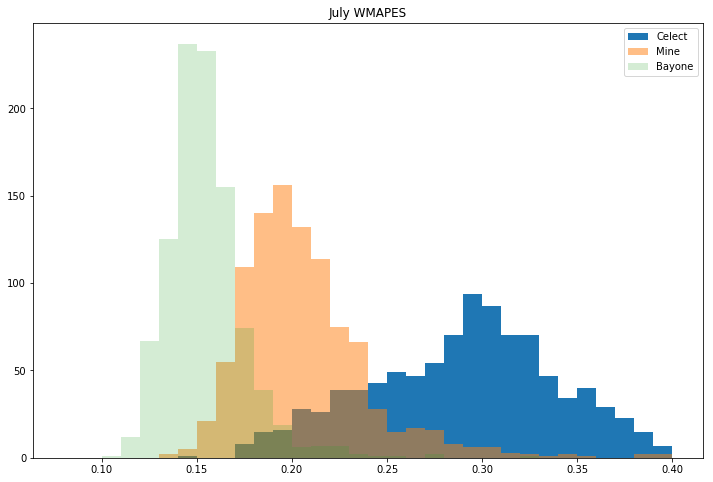

In [25]:
bins_0_1 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1.0]

bins_0_04 = [0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
             0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27, 0.28,
             0.29, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 
             0.36, 0.37, 0.38, 0.39, 0.40]
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
counts, bins, fig = ax1.hist(wmapes_celect[wmapes_celect['WMAPE'].notnull()]['WMAPE'], 
                            bins=bins_0_04)
counts, bins, fig = ax1.hist(wmapes_mine[wmapes_mine['WMAPE'].notnull()].WMAPE, 
                            bins=bins_0_04, alpha=0.5)
counts, bins, fig = ax1.hist(wmapes_bayone[wmapes_bayone['WMAPE'].notnull()].WMAPE, 
                            bins=bins_0_04, alpha=0.2)
ax1.set_title('July WMAPES')
ax1.legend(['Celect', 'Mine', 'Bayone'])
plt.savefig('./CelectResults/July_WMAPE_celect_mineIN.png')

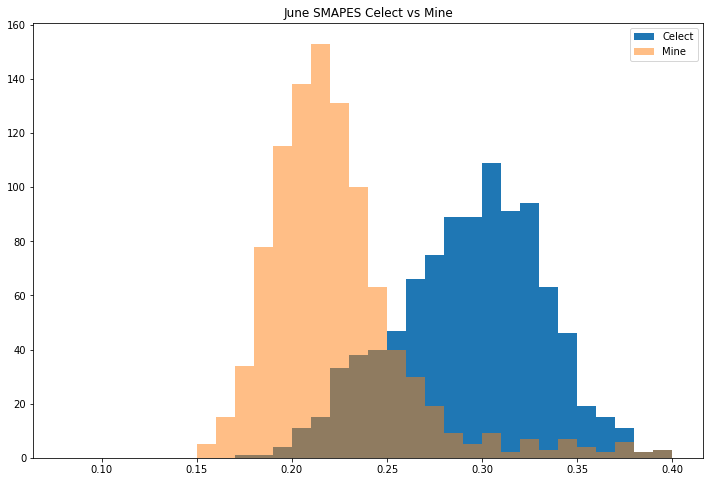

In [26]:
bins_0_1 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1.0]

bins_0_04 = [0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
             0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27, 0.28,
             0.29, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 
             0.36, 0.37, 0.38, 0.39, 0.40]
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
counts, bins, fig = ax1.hist(wmapes_celect[wmapes_celect['SMAPE'].notnull()]['SMAPE'], 
                            bins=bins_0_04)
counts, bins, fig = ax1.hist(wmapes_mine[wmapes_mine['SMAPE'].notnull()]['SMAPE'], 
                            bins=bins_0_04, alpha=0.5)
ax1.set_title('June SMAPES Celect vs Mine')
ax1.legend(['Celect', 'Mine'])
plt.savefig('./CelectResults/June_SMAPE_celect_mine.png')

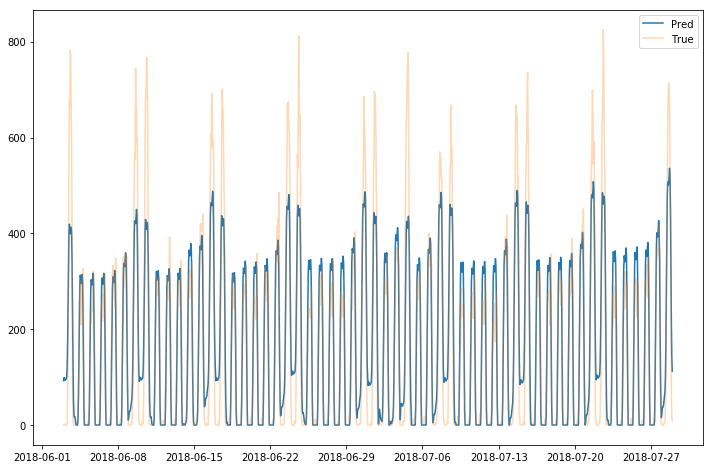

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

store_id = 994
ax1.plot(df[df['store_id'] == store_id].TRFFC_DTE, df[df['store_id'] == store_id].trffc_pred)
ax1.plot(df[df['store_id'] == store_id].TRFFC_DTE, df[df['store_id'] == store_id].trffc_true, alpha=0.3)
ax1.legend(['Pred', 'True'])
plt.show()

### Get the SMAPE from Celect themselves

In [28]:
df2 = pd.read_csv('./CelectResults/traffic-in-backtest-sample.csv')

In [29]:
df2.head(3)

,period_start,period_end,store_id,product_id,demand,model-last-updated,true_value,store_smape_hourly_14,store_smape_hourly_28,store_smape_hourly_56,store_smape_daily_14,store_smape_daily_28,store_smape_daily_56
0,2018-06-03T00:00:00,2018-06-03T01:00:00,7,NaN,53.233763,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603
1,2018-06-03T01:00:00,2018-06-03T02:00:00,7,NaN,53.771452,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603
2,2018-06-03T02:00:00,2018-06-03T03:00:00,7,NaN,52.156366,2018-10-31T13:08:37.854613,0,0.302065,0.303287,0.319641,0.069472,0.110183,0.122603


In [30]:
d2_celect = {}
d2_celect['store'] = []
d2_celect['SMAPE'] = []

for store_id in [i for i in store_list_mine if i in store_list_celect]:
    t = df2[df2['store_id'] == store_id].store_smape_hourly_56.unique().tolist()[0]
    d2_celect['store'].append(store_id)
    d2_celect['SMAPE'].append(t)

In [31]:
wmapes_celect_calculdated = pd.DataFrame(d2_celect)
wmapes_celect_calculdated.to_csv('./CelectResults/Comparison_celect_calculated_June_WMAPEs.csv')

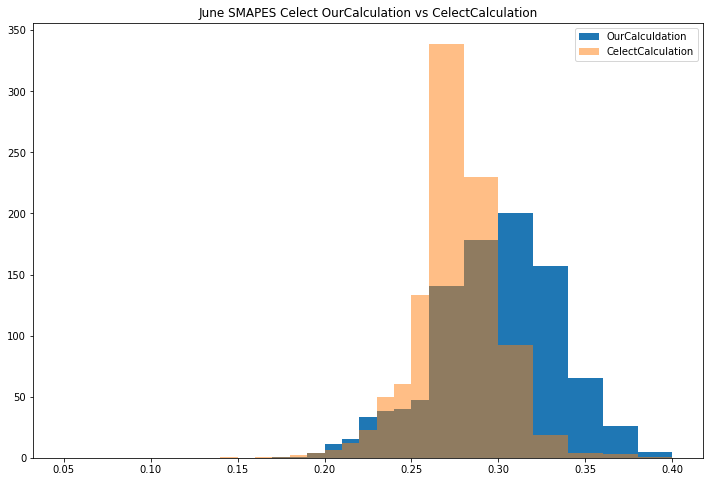

In [32]:
bins_0_1 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.5,0.55,0.6,0.65,0.7,0.8,0.9,1.0]

bins_0_04 = [0.05,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,
                                  0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.28,0.3,0.32,0.34,
                                  0.36,0.38,0.40]
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
counts, bins, fig = ax1.hist(wmapes_celect[wmapes_celect['SMAPE'].notnull()]['SMAPE'], 
                            bins=bins_0_04)
counts, bins, fig = ax1.hist(wmapes_celect_calculdated[wmapes_celect_calculdated['SMAPE'].notnull()]['SMAPE'], 
                            bins=bins_0_04, alpha=0.5)
ax1.set_title('June SMAPES Celect OurCalculation vs CelectCalculation')
ax1.legend(['OurCalculdation', 'CelectCalculation'])
plt.savefig('./CelectResults/June_SMAPE_celect_ourcalculation_celectcalculation.png')

### Check my daily predictions

In [34]:
df_daily = pd.read_csv(
    './000Deliverables/Clean_Daily_V311_APE_XGB_9_70_3_03_OUT/Clean_Daily_V311_APE_XGB_9_70_3_03_OUT.csv')

df_daily['trn_sls_dte'] = pd.to_datetime(df_daily['Date'], infer_datetime_format=True)
df_daily['Date'] = df_daily['trn_sls_dte'].dt.strftime("%Y-%m-%d")

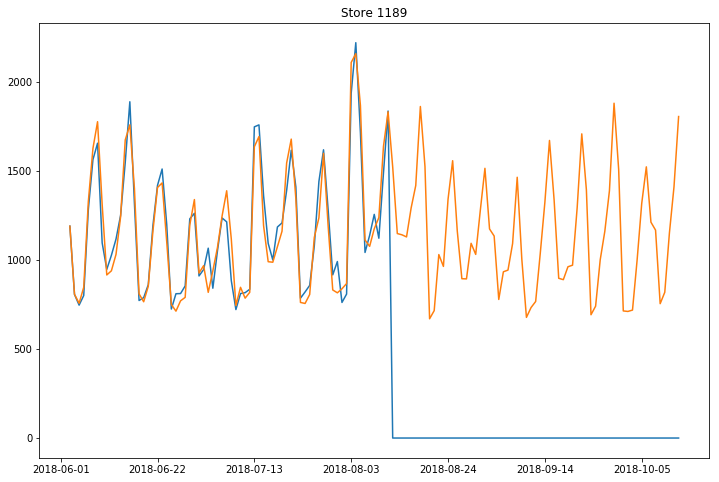

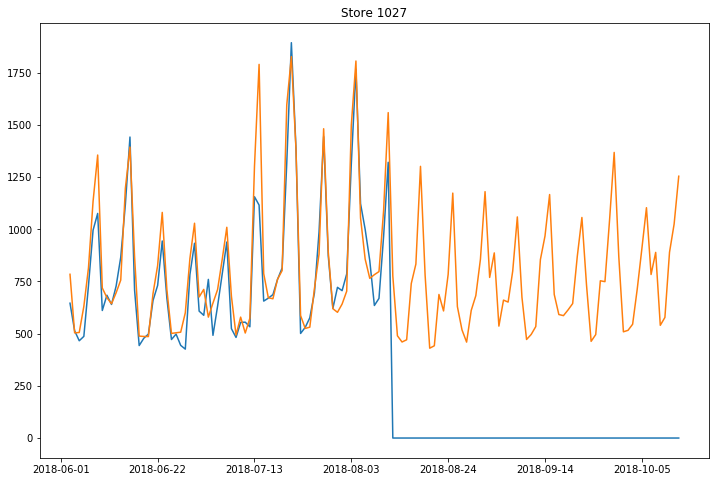

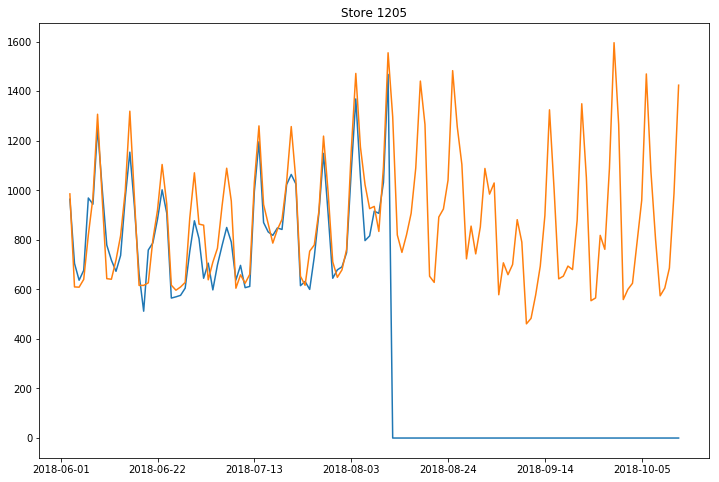

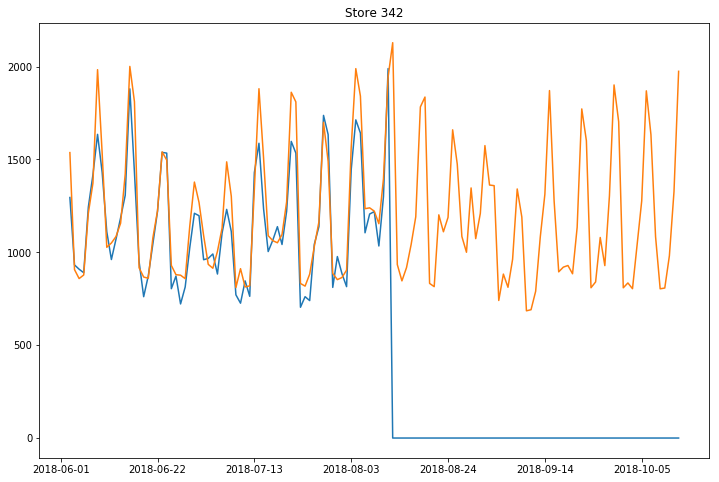

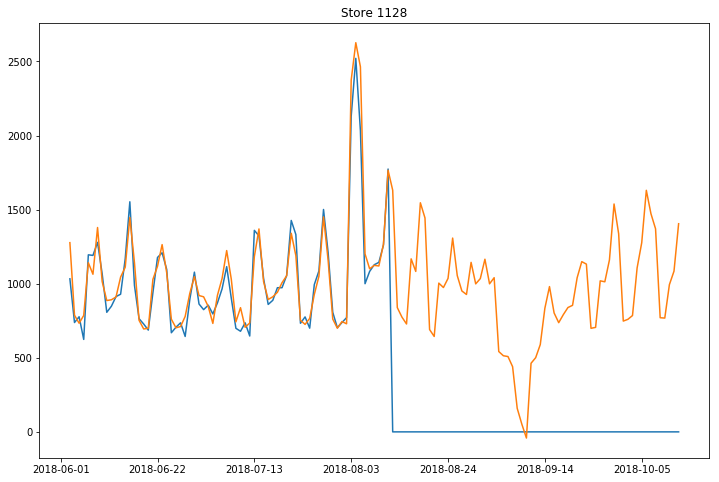

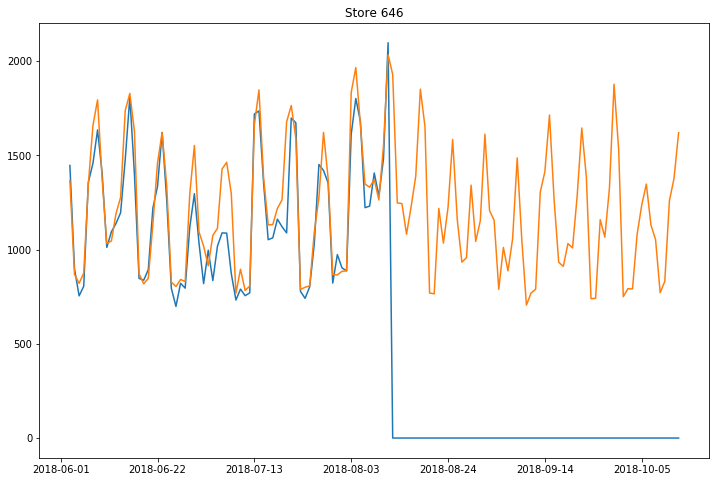

In [35]:
sample_list = []

for i in range(10):
    x = np.random.randint(1, 1531)
    if x in store_list_mine and x not in sample_list:
        sample_list.append(x)

for store_id in sample_list:
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(111)
    ax1.plot(df_daily[df_daily['STR_ID'] == store_id].trn_sls_dte, df_daily[df_daily['STR_ID'] == store_id].VSTR_IN_CNT)
    ax1.plot(df_daily[df_daily['STR_ID'] == store_id].trn_sls_dte, df_daily[df_daily['STR_ID'] == store_id].VSTR_IN_CNT_pred)
    ax1.set_title('Store ' + str(store_id))
    plt.show()